# Ray Train etc ...


In [1]:
import ray
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ray.shutdown()

In [3]:
ray.init()

2023-03-15 22:19:40,026	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.9.16
Ray version:,2.3.0


In [4]:
# Load data.
dataset = ray.data.read_csv("s3://anonymous@air-example-data/breast_cancer.csv").repartition(6)

# Split data into train and validation.
train_dataset, valid_dataset = dataset.train_test_split(test_size=0.3)

# Create a test dataset by dropping the target column.
test_dataset = valid_dataset.drop_columns(cols=["target"])

2023-03-15 22:19:47,833	WARNING read_api.py:330 -- ⚠️  The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
2023-03-15 22:19:47,856	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[read] -> AllToAllOperator[repartition]
Repartition: 100%|█████████████████████████████| 6/6 [00:00<00:00, 24.97it/s]


In [5]:
# Create a preprocessor to scale some columns.
from ray.data.preprocessors import StandardScaler

preprocessor = StandardScaler(columns=["mean radius", "mean texture"])

In [6]:
from ray.air.config import ScalingConfig
from ray.train.xgboost import XGBoostTrainer

trainer = XGBoostTrainer(
    scaling_config=ScalingConfig(
        # Number of workers to use for data parallelism.
        num_workers=1,#2,
        resources_per_worker={'CPU': 6},
        # Whether to use GPU acceleration.
        use_gpu=False,
        # Make sure to leave some CPUs free for Ray Data operations.
        _max_cpu_fraction_per_node=0.9,
    ),
    label_column="target",
    num_boost_round=20,
    params={
        # XGBoost specific params
        "objective": "binary:logistic",
        # "tree_method": "gpu_hist",  # uncomment this to use GPUs.
        "eval_metric": ["logloss", "error"],
    },
    datasets={"train": train_dataset, "valid": valid_dataset},
    preprocessor=preprocessor,
)
result = trainer.fit()
print(result.metrics)

(XGBoostTrainer pid=3730) 2023-03-15 22:19:51,971	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=3730) 2023-03-15 22:19:53,202	WARNING plan.py:523 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(XGBoostTrainer pid=3730) 2023-03-15 22:19:53,203	WARNING plan.py:523 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(XGBoostTrainer pid=3730) 2023-03-15 22:19:53,203	INFO bulk_executor

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_80574_00000,2023-03-15_22-19-56,True,,48c9950b627749589efcd140a4837dd3,0,Andrews-MacBook-Pro.local,21,127.0.0.1,3730,True,4.44161,0.0450728,4.44161,1678918796,0,,0,0.0186958,21,80574_00000,0.0350877,0.0926329,0.0051322


2023-03-15 22:19:56,419	INFO tune.py:798 -- Total run time: 6.44 seconds (5.68 seconds for the tuning loop).


{'train-logloss': 0.01869584539561209, 'train-error': 0.0, 'valid-logloss': 0.09263286689753857, 'valid-error': 0.03508771929824561, 'time_this_iter_s': 0.04507279396057129, 'should_checkpoint': True, 'done': True, 'timesteps_total': None, 'episodes_total': None, 'training_iteration': 21, 'trial_id': '80574_00000', 'experiment_id': '48c9950b627749589efcd140a4837dd3', 'date': '2023-03-15_22-19-56', 'timestamp': 1678918796, 'time_total_s': 4.441609859466553, 'pid': 3730, 'hostname': 'Andrews-MacBook-Pro.local', 'node_ip': '127.0.0.1', 'config': {}, 'time_since_restore': 4.441609859466553, 'timesteps_since_restore': 0, 'iterations_since_restore': 21, 'warmup_time': 0.005132198333740234, 'experiment_tag': '0'}


In [7]:
def train_xgboost_model(num_workers, num_cpus):
    trainer = XGBoostTrainer(
    scaling_config=ScalingConfig(
        # Number of workers to use for data parallelism.
        num_workers=num_workers,
        resources_per_worker={'CPU': num_cpus},
        # Whether to use GPU acceleration.
        use_gpu=False,
        # Make sure to leave some CPUs free for Ray Data operations.
        _max_cpu_fraction_per_node=0.9,
    ),
    label_column="target",
    num_boost_round=20,
    params={
        # XGBoost specific params
        "objective": "binary:logistic",
        # "tree_method": "gpu_hist",  # uncomment this to use GPUs.
        "eval_metric": ["logloss", "error"],
    },
    datasets={"train": train_dataset, "valid": valid_dataset},
    preprocessor=preprocessor,
    )
    result = trainer.fit()
    return result


In [8]:
trial_results = []

num_workers=1
for num_cpus in [1,2,3,4,5,6]:
    result = train_xgboost_model(num_workers=num_workers, num_cpus=num_cpus)
    result_dict = result.metrics
    result_dict['num_workers'] = num_workers
    result_dict['num_cpus'] = num_cpus
    trial_results.append(result_dict)
    
num_workers=2
for num_cpus in [1,2,3]:
    result = train_xgboost_model(num_workers=num_workers, num_cpus=num_cpus)
    result_dict = result.metrics
    result_dict['num_workers'] = num_workers
    result_dict['num_cpus'] = num_cpus
    trial_results.append(result_dict)

pd.DataFrame(trial_results)  

(XGBoostTrainer pid=3741) 2023-03-15 22:19:57,624	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=3741) 2023-03-15 22:19:57,643	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3741) 2023-03-15 22:19:57,681	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3741) /Users/apmcm/Library/Caches/pypoetry/virtualenvs/mlewp2-ray-bRNhCFd1-py3.9/lib/python3.9/site-packages/xgboost_ray/main.py:473: UserWarning: `num_actors` in `ray_params` is smaller than 2 (1). XGBoost will NOT be distributed!
(XGBoostTrainer pid=3741)   warnings.warn(
(XGBoostTrainer pid=3741) 2023-03-15 22:20:02,084	INFO tracker.py:218 -- start listen on 127.0.0.1:60227
(XGBoostTrainer pid=3741) 2023-03-15 22:20:02,097	INFO tracker.py:382 -- @tracker All of 1 nodes getting started
(_RemoteRayXGBoostActor pid=3755)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_842fe_00000,2023-03-15_22-20-03,True,,981f6a7bfd8c4c93b45a80135de5502b,0,Andrews-MacBook-Pro.local,21,127.0.0.1,3741,True,6.08439,0.09234,6.08439,1678918803,0,,0,0.0186958,21,842fe_00000,0.0350877,0.0926329,0.00559115


2023-03-15 22:20:03,716	INFO tune.py:798 -- Total run time: 7.28 seconds (7.28 seconds for the tuning loop).


(XGBoostTrainer pid=3758) 2023-03-15 22:20:05,275	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=3758) 2023-03-15 22:20:06,589	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3758) 2023-03-15 22:20:06,608	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3758) /Users/apmcm/Library/Caches/pypoetry/virtualenvs/mlewp2-ray-bRNhCFd1-py3.9/lib/python3.9/site-packages/xgboost_ray/main.py:473: UserWarning: `num_actors` in `ray_params` is smaller than 2 (1). XGBoost will NOT be distributed!
(XGBoostTrainer pid=3758)   warnings.warn(
(XGBoostTrainer pid=3758) 2023-03-15 22:20:08,116	INFO tracker.py:218 -- start listen on 127.0.0.1:60331
(XGBoostTrainer pid=3758) 2023-03-15 22:20:08,128	INFO tracker.py:382 -- @tracker All of 1 nodes getting started
(_RemoteRayXGBoostActor pid=3763)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_8887e_00000,2023-03-15_22-20-09,True,,049d6e153ce44dffbace2643f1cf1ffc,0,Andrews-MacBook-Pro.local,21,127.0.0.1,3758,True,4.44467,0.075655,4.44467,1678918809,0,,0,0.0186958,21,8887e_00000,0.0350877,0.0926329,0.00535774


2023-03-15 22:20:09,727	INFO tune.py:798 -- Total run time: 6.01 seconds (6.00 seconds for the tuning loop).


(XGBoostTrainer pid=3766) 2023-03-15 22:20:11,298	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=3766) 2023-03-15 22:20:11,313	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3766) 2023-03-15 22:20:11,342	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3766) /Users/apmcm/Library/Caches/pypoetry/virtualenvs/mlewp2-ray-bRNhCFd1-py3.9/lib/python3.9/site-packages/xgboost_ray/main.py:473: UserWarning: `num_actors` in `ray_params` is smaller than 2 (1). XGBoost will NOT be distributed!
(XGBoostTrainer pid=3766)   warnings.warn(
(XGBoostTrainer pid=3766) 2023-03-15 22:20:14,737	INFO tracker.py:218 -- start listen on 127.0.0.1:60448
(XGBoostTrainer pid=3766) 2023-03-15 22:20:14,751	INFO tracker.py:382 -- @tracker All of 1 nodes getting started
(_RemoteRayXGBoostActor pid=3773)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_8c1d1_00000,2023-03-15_22-20-17,True,,a36085e29bc14308b5337937580fb63c,0,Andrews-MacBook-Pro.local,21,127.0.0.1,3766,True,6.06984,0.990279,6.06984,1678918817,0,,0,0.0186958,21,8c1d1_00000,0.0350877,0.0926329,0.00533581


2023-03-15 22:20:17,392	INFO tune.py:798 -- Total run time: 7.66 seconds (7.65 seconds for the tuning loop).


(XGBoostTrainer pid=3776) 2023-03-15 22:20:18,985	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=3776) 2023-03-15 22:20:19,348	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3776) 2023-03-15 22:20:19,384	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3776) /Users/apmcm/Library/Caches/pypoetry/virtualenvs/mlewp2-ray-bRNhCFd1-py3.9/lib/python3.9/site-packages/xgboost_ray/main.py:473: UserWarning: `num_actors` in `ray_params` is smaller than 2 (1). XGBoost will NOT be distributed!
(XGBoostTrainer pid=3776)   warnings.warn(
(XGBoostTrainer pid=3776) 2023-03-15 22:20:21,231	INFO tracker.py:218 -- start listen on 127.0.0.1:60550
(XGBoostTrainer pid=3776) 2023-03-15 22:20:21,243	INFO tracker.py:382 -- @tracker All of 1 nodes getting started
(_RemoteRayXGBoostActor pid=3781)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_90af5_00000,2023-03-15_22-20-22,True,,4cdbe15f89064698bab1f63c5199fcf4,0,Andrews-MacBook-Pro.local,21,127.0.0.1,3776,True,3.90955,0.135989,3.90955,1678918822,0,,0,0.0186958,21,90af5_00000,0.0350877,0.0926329,0.00527096


2023-03-15 22:20:22,920	INFO tune.py:798 -- Total run time: 5.52 seconds (5.51 seconds for the tuning loop).


(XGBoostTrainer pid=3784) 2023-03-15 22:20:24,522	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=3784) 2023-03-15 22:20:24,767	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3784) 2023-03-15 22:20:24,786	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3784) /Users/apmcm/Library/Caches/pypoetry/virtualenvs/mlewp2-ray-bRNhCFd1-py3.9/lib/python3.9/site-packages/xgboost_ray/main.py:473: UserWarning: `num_actors` in `ray_params` is smaller than 2 (1). XGBoost will NOT be distributed!
(XGBoostTrainer pid=3784)   warnings.warn(
(XGBoostTrainer pid=3784) 2023-03-15 22:20:26,373	INFO tracker.py:218 -- start listen on 127.0.0.1:60631
(XGBoostTrainer pid=3784) 2023-03-15 22:20:26,387	INFO tracker.py:382 -- @tracker All of 1 nodes getting started
(_RemoteRayXGBoostActor pid=3787)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_93fa4_00000,2023-03-15_22-20-27,True,,2930a4567a2e44a5a85e8cebc2bbedf0,0,Andrews-MacBook-Pro.local,21,127.0.0.1,3784,True,3.44766,0.064743,3.44766,1678918827,0,,0,0.0186958,21,93fa4_00000,0.0350877,0.0926329,0.00524616


2023-03-15 22:20:27,977	INFO tune.py:798 -- Total run time: 5.05 seconds (5.05 seconds for the tuning loop).


(XGBoostTrainer pid=3790) 2023-03-15 22:20:29,608	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=3790) 2023-03-15 22:20:29,622	WARNING plan.py:523 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(XGBoostTrainer pid=3790) 2023-03-15 22:20:29,623	WARNING plan.py:523 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(XGBoostTrainer pid=3790) 2023-03-15 22:20:29,624	INFO bulk_executor

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_96fdc_00000,2023-03-15_22-20-32,True,,c6a2c1e00f19448a92f17c5aa0beb645,0,Andrews-MacBook-Pro.local,21,127.0.0.1,3790,True,3.21241,0.0535638,3.21241,1678918832,0,,0,0.0186958,21,96fdc_00000,0.0350877,0.0926329,0.00541019


2023-03-15 22:20:32,828	INFO tune.py:798 -- Total run time: 4.85 seconds (4.84 seconds for the tuning loop).


(XGBoostTrainer pid=3795) 2023-03-15 22:20:33,960	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=3795) 2023-03-15 22:20:33,977	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3795) 2023-03-15 22:20:34,039	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3795) 2023-03-15 22:20:38,776	INFO tracker.py:218 -- start listen on 127.0.0.1:60848
(XGBoostTrainer pid=3795) 2023-03-15 22:20:38,791	INFO tracker.py:382 -- @tracker All of 2 nodes getting started
(_RemoteRayXGBoostActor pid=3804) [22:20:38] task [xgboost.ray]:5873821248 got new rank 0
(_RemoteRayXGBoostActor pid=3805) [22:20:38] task [xgboost.ray]:5295138656 got new rank 1
(XGBoostTrainer pid=3795) 2023-03-15 22:20:39,221	INFO tracker.py:388 -- @tracker All nodes finishes job


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_99e22_00000,2023-03-15_22-20-41,True,,970039a032ed4dd7a6135a714148c41c,0,Andrews-MacBook-Pro.local,21,127.0.0.1,3795,True,7.39435,0.944245,7.39435,1678918841,0,,0,0.0182011,21,99e22_00000,0.0411765,0.0957057,0.00515628


2023-03-15 22:20:41,377	INFO tune.py:798 -- Total run time: 8.54 seconds (8.53 seconds for the tuning loop).


(XGBoostTrainer pid=3808) 2023-03-15 22:20:43,055	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=3808) 2023-03-15 22:20:43,567	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3808) 2023-03-15 22:20:43,611	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=3808) 2023-03-15 22:20:46,475	INFO tracker.py:218 -- start listen on 127.0.0.1:60952
(XGBoostTrainer pid=3808) 2023-03-15 22:20:46,497	INFO tracker.py:382 -- @tracker All of 2 nodes getting started
(_RemoteRayXGBoostActor pid=3815) [22:20:46] task [xgboost.ray]:5972649536 got new rank 0
(_RemoteRayXGBoostActor pid=3816) [22:20:46] task [xgboost.ray]:5727430352 got new rank 1
(XGBoostTrainer pid=3808) 2023-03-15 22:20:47,633	INFO tracker.py:388 -- @tracker All nodes finishes job


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_9efb1_00000,2023-03-15_22-20-49,True,,a31f492aad084857b426d27595e3777a,0,Andrews-MacBook-Pro.local,21,127.0.0.1,3808,True,6.00897,0.284432,6.00897,1678918849,0,,0,0.0182011,21,9efb1_00000,0.0411765,0.0957057,0.00548029


2023-03-15 22:20:49,079	INFO tune.py:798 -- Total run time: 7.69 seconds (7.68 seconds for the tuning loop).


(XGBoostTrainer pid=3819) 2023-03-15 22:20:50,622	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=3819) 2023-03-15 22:20:50,867	WARNING plan.py:523 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(XGBoostTrainer pid=3819) 2023-03-15 22:20:50,867	WARNING plan.py:523 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(XGBoostTrainer pid=3819) 2023-03-15 22:20:50,868	INFO bulk_executor

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_a3923_00000,2023-03-15_22-20-55,True,,4b6fcad79208407599ea67b4e40cf247,0,Andrews-MacBook-Pro.local,21,127.0.0.1,3819,True,4.59786,0.959963,4.59786,1678918855,0,,0,0.0182011,21,a3923_00000,0.0411765,0.0957057,0.00498986


2023-03-15 22:20:55,236	INFO tune.py:798 -- Total run time: 6.15 seconds (6.14 seconds for the tuning loop).


,train-logloss,train-error,valid-logloss,valid-error,time_this_iter_s,should_checkpoint,done,timesteps_total,episodes_total,training_iteration,...,hostname,node_ip,config,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,experiment_tag,num_workers,num_cpus
0,0.018696,0.0,0.092633,0.035088,0.092340,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},6.084385,0,21,0.005591,0,1,1
1,0.018696,0.0,0.092633,0.035088,0.075655,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},4.444673,0,21,0.005358,0,1,2
2,0.018696,0.0,0.092633,0.035088,0.990279,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},6.069839,0,21,0.005336,0,1,3
3,0.018696,0.0,0.092633,0.035088,0.135989,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},3.909547,0,21,0.005271,0,1,4
4,0.018696,0.0,0.092633,0.035088,0.064743,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},3.447659,0,21,0.005246,0,1,5
5,0.018696,0.0,0.092633,0.035088,0.053564,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},3.212414,0,21,0.005410,0,1,6
6,0.018201,0.0,0.095706,0.041176,0.944245,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},7.394352,0,21,0.005156,0,2,1
7,0.018201,0.0,0.095706,0.041176,0.284432,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},6.008974,0,21,0.005480,0,2,2
8,0.018201,0.0,0.095706,0.041176,0.959963,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},4.597858,0,21,0.004990,0,2,3


An interesting result that as the number of workers goes up, so does this time. This is actually because increasing the number of workers on a single node won't reall

In [9]:
result.metrics_dataframe.columns

Index(['train-logloss', 'train-error', 'valid-logloss', 'valid-error',
       'time_this_iter_s', 'done', 'timesteps_total', 'episodes_total',
       'training_iteration', 'trial_id', 'experiment_id', 'date', 'timestamp',
       'time_total_s', 'pid', 'hostname', 'node_ip', 'time_since_restore',
       'timesteps_since_restore', 'iterations_since_restore', 'warmup_time'],
      dtype='object')

In [10]:
result.metrics_dataframe[['training_iteration','train-logloss']]

,training_iteration,train-logloss
0,1,0.464118
1,2,0.333279
2,3,0.252174
3,4,0.192882
4,5,0.149095
5,6,0.117648
6,7,0.095098
7,8,0.078028
8,9,0.064818
9,10,0.055212


In [13]:
pd.DataFrame(trial_results)[['num_workers','num_cpus', 'time_total_s']]

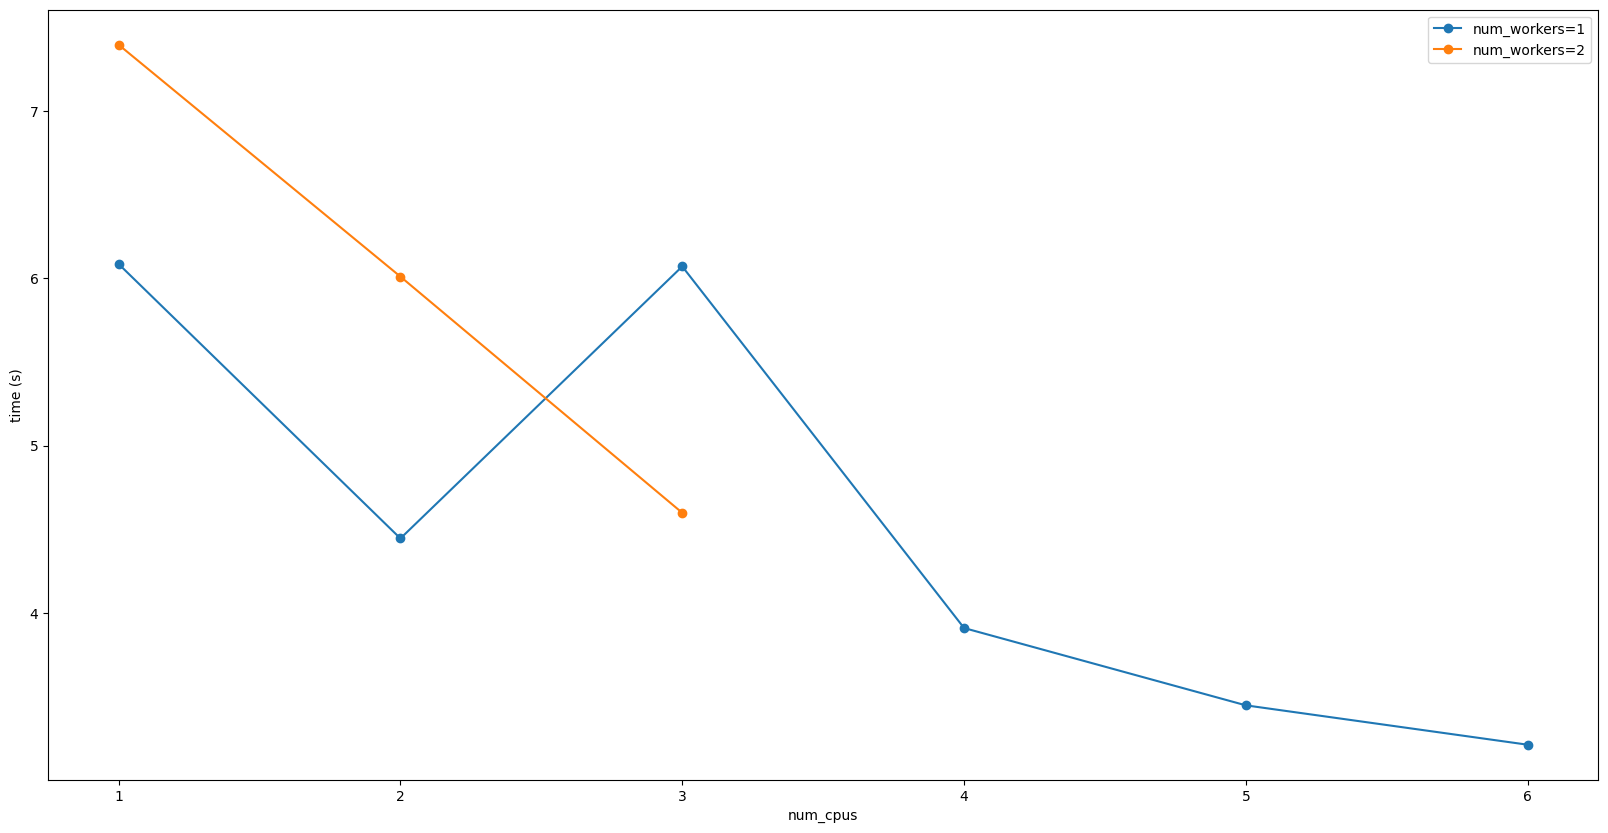

In [32]:
plt.figure(figsize=(20,10))
pd.DataFrame(trial_results)[['num_workers','num_cpus', 'time_total_s']].\
set_index('num_cpus').\
groupby('num_workers')['time_total_s'].plot(
    legend=True, marker='o',
)
plt.ylabel('time (s)')
plt.legend(['num_workers=1', 'num_workers=2'])

# Ray AIR attempt

In [ ]:
import numpy as np
from ray.data.preprocessors import Concatenator, Chain, StandardScaler

# Create a preprocessor to scale some columns and concatenate the result.
preprocessor = Chain(
    StandardScaler(columns=["mean radius", "mean texture"]),
    Concatenator(exclude=["target"], dtype=np.float32),
)

In [ ]:
import torch
import torch.nn as nn

from ray import train
from ray.air import session
from ray.air.config import ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer


def create_model(input_features):
    return nn.Sequential(
        nn.Linear(in_features=input_features, out_features=16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid(),
    )


def train_loop_per_worker(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["num_epochs"]
    num_features = config["num_features"]

    # Get the Ray Dataset shard for this data parallel worker,
    # and convert it to a PyTorch Dataset.
    train_data = session.get_dataset_shard("train")
    # Create model.
    model = create_model(num_features)
    model = train.torch.prepare_model(model)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for cur_epoch in range(epochs):
        for batch in train_data.iter_torch_batches(
            batch_size=batch_size, dtypes=torch.float32
        ):
            # "concat_out" is the output column of the Concatenator.
            inputs, labels = batch["concat_out"], batch["target"]
            optimizer.zero_grad()
            predictions = model(inputs)
            train_loss = loss_fn(predictions, labels.unsqueeze(1))
            train_loss.backward()
            optimizer.step()
        loss = train_loss.item()
        session.report({"loss": loss}, checkpoint=TorchCheckpoint.from_model(model))


num_features = len(train_dataset.schema().names) - 1

trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config={
        "batch_size": 128,
        "num_epochs": 20,
        "num_features": num_features,
        "lr": 0.001,
    },
    scaling_config=ScalingConfig(
        num_workers=3,  # Number of workers to use for data parallelism.
        use_gpu=False,
        trainer_resources={"CPU": 0},  # so that the example works on Colab.
    ),
    datasets={"train": train_dataset},
    preprocessor=preprocessor,
)

In [ ]:
# Execute training.
result = trainer.fit()
# print(f"Last result: {result.metrics}")
# # Last result: {'loss': 0.6559339960416158, ...}